# Kalman Filter

The kalman filter is often used for tracking objects.

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
class Gaussian:
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma

    def plot(self):
        x = np.linspace(self.mu - 3*self.sigma, self.mu + 3*self.sigma, 100)
        y = np.exp(-0.5 * ((x - self.mu) / self.sigma)**2) / (self.sigma * np.sqrt(2*np.pi))
        return x,y

    def __add__(self, other):
        mu = self.mu + other.mu
        sigma = np.sqrt(self.sigma**2 + other.sigma**2)
        return Gaussian(mu, sigma)

    def __mul__(self, other):
        mu = (self.sigma**2 * other.mu + other.sigma**2 * self.mu) / (self.sigma**2 + other.sigma**2)
        sigma = np.sqrt(self.sigma**2*other.sigma**2 / (self.sigma**2 + other.sigma**2))
        return Gaussian(mu, sigma)

    def __repr__(self):
        return f'N(mu={self.mu}, sigma={self.sigma})'

## Gaussian Intuition

First, we need to talk about gaussian and the intuition behind them.
A Gaussian distribution, also known as a normal distribution, is a way to describe how values are spread out. It is often used to represent real-world data that clusters around a central value.

Imagine you are measuring the heights of a large group of people:
* Mean ($\mu$): The average height is 170 cm.
* Standard Deviation ($\sigma$): The standard deviation is 10 cm.

### Mathmatical Details
Given two gaussian distributions, the resulting Gaussian distribution after addition is:

$$ \mu = \mu_1 + \mu_2 $$
$$ \sigma = \sqrt{\sigma_1^2 + \sigma_2^2} $$

Given two gaussian distributions, the resulting Gaussian distribution after multiplication is:

$$ \sigma = \frac{\sigma_1^2 \sigma_2^2}{\sigma_1^2 + \sigma_2^2} $$
$$ \mu = \sigma \left(\frac{\mu_1}{\sigma_1^2} + \frac{\mu_2}{\sigma_2^2}\right) $$

Text(0, 0.5, 'Probability Density')

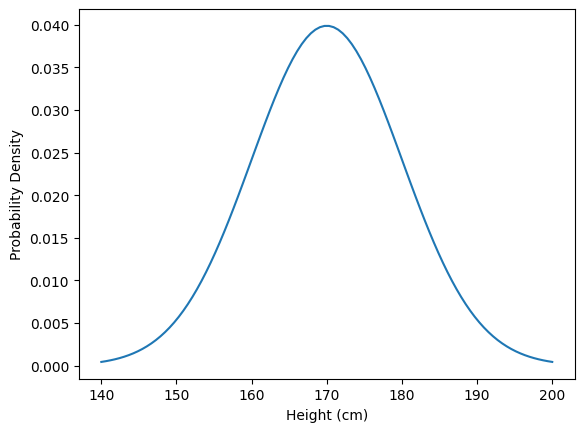

In [3]:
measurement = Gaussian(170, 10)
plt.plot(*measurement.plot())
plt.xlabel('Height (cm)')
plt.ylabel('Probability Density')

We repeat the measurement and again receive the same results. Best case, now we are even more confident, that the average person is 170cm tall. How can we express this in mathematics? We multiply our measurements, e.g. the normal distributions.

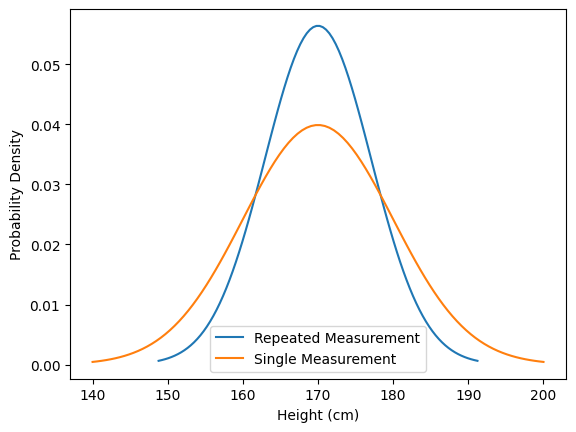

In [4]:
repeated_measurement = measurement * measurement
plt.plot(*repeated_measurement.plot(), label='Repeated Measurement')
plt.plot(*measurement.plot(), label='Single Measurement')
plt.xlabel('Height (cm)')
plt.ylabel('Probability Density')
plt.legend()

What would happen if we measure another time, but this time, our average height is above 170, e.g. 200? We would assume the truth lies somewhere between 170 and 200, right?

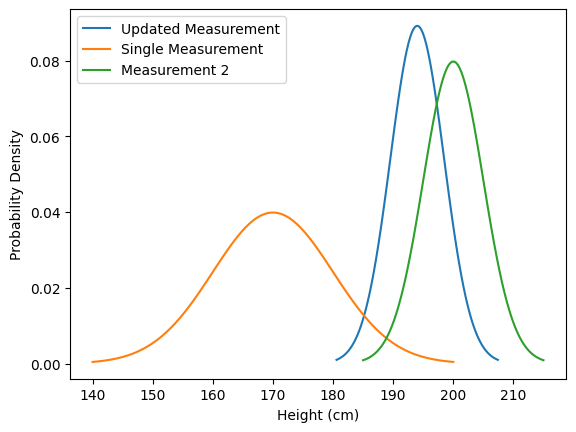

In [5]:
measurement_2 = Gaussian(200, 5)
updated_measurement = measurement * measurement_2
plt.plot(*updated_measurement.plot(), label='Updated Measurement')
plt.plot(*measurement.plot(), label='Single Measurement')
plt.plot(*measurement_2.plot(), label='Measurement 2')
plt.xlabel('Height (cm)')
plt.ylabel('Probability Density')
plt.legend()

## From Gaussian to Kalman Filter

The Kalman filter is an object tracker. More general speaking it is a state estimator which uses the properties of the gaussian distribution.

It works in four steps:
1. Generate an initial estimate of the state (e.g., velocity) represented as a Gaussian distribution with mean ($\mu_0$) and variance ($\sigma_0^2$).
2. Predict the next state using the system model. This gives a new Gaussian distribution with updated mean ($\mu_{\text{pred}}$) and variance ($\sigma_{\text{pred}}^2$).
3. Obtain a new measurement, which is another Gaussian distribution with mean ($\mu_{\text{meas}}$) and variance ($\sigma_{\text{meas}}^2$).
4. Combine the predicted state and the measurement to get a new, more accurate estimate of the state.
The updated state is a Gaussian distribution with a new mean ($\mu_{\text{update}}$) and variance ($\sigma_{\text{update}}^2$).


I have visualized the flowchart. You can find more or less the same in the code below, but it is helpful to visualize the individual pieces and how they interact to get a feeling for it. I have divided the boxes into three types

1. In blue, the main steps are visualized piecing the state updates together.
2. Covariances (a measure for uncertainty) are visualized in yellow
3. The gain is depicted in green. The gain is a very central piece.

Let us look at an practical example. We want to estimate the position of a moving car. The car has a constant acceleration thus increasing the speed over time.

1. We make a state estimate, initially this can be random. In our case, we estimate the position and velocity of the car. Additionally, we calculate the uncertainty of this estimate using the covariance.
2. We measure the position of our car and maybe the uncertainty of that measurement. In our case we ignore it, since we are in a perfect world.
3. With the estimate and the measurement, we calculate the innovation: The difference between estimate and measurement.
4. Now, the Kalman gain. The gain basically tells us, which of the two we should believe in more. Either the measurement or the estimate. If the gain is high, the measurement uncertainity is low and vice versa. 
5. In the last step, we update our estimate (from step 1) using the measurement. We use the gain as a factor to weigh the innovation.


![Kalman Filter](images/kalman-filter.drawio.png)

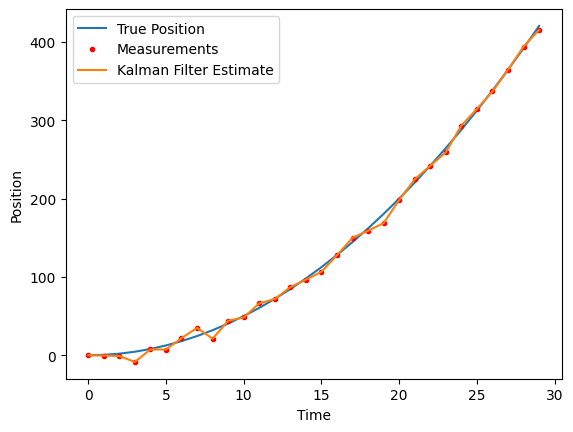

In [7]:
dt = 1.0
steps = 30

# The state transition (A) matrix represents a constant velocity model, x_1 = x_0 + v_0 * dt
A = np.array([[1, dt],
              [0, 1]])

# Control input matrix (B) represents the change in velocity controlled by acceleration, u = 0.5 * a * t^2
B = np.array([[0.5 * dt**2], [dt]])

# state vector, [position; velocity]
x = np.array([[0], [20]])

# We directly measure the position, so the observation matrix (H) is just a selection matrix
H = np.array([[1, 0]])

# Process noise covariance (Q), represents the uncertainty in the model
Q = np.array([[0.25 * dt**4,    0.5 * dt**3],
              [0.5 * dt**3,     dt**2]])

# Initial state covariance
P = np.eye(2)

# Generate truth and noisy measurements
true_state = np.zeros((2, steps))
measurements = np.zeros(steps)
for t in range(1, steps):
    true_state[:, t] = np.dot(A, true_state[:, t-1]) + B.flatten()
    measurements[t] = true_state[0, t] + np.random.normal(0, 5)

estimates = np.zeros((2, steps))
for t in range(steps):
    # Step 1, State estimate
    x = A @ x
    P = A @ P @ A.T + Q

    # Step 2, Measurement
    z = np.array([[measurements[t]]])

    # Step 3, Innovation
    y = z - H @ x
    # S is the innovation covariance, the sum of the measurement covariance and the estimated covariance
    S = H @ P @ H.T

    # Step 4, Kalman Gain
    K = P @ H.T @ np.linalg.inv(S)
    # Step 5, Update the state estimate
    x = x + K @ y
    P = (np.eye(2) - K @ H) @ P
    estimates[:, t] = x.flatten()

plt.plot(true_state[0], label='True Position')
plt.plot(measurements, 'r.', label='Measurements')
plt.plot(estimates[0], label='Kalman Filter Estimate')
plt.xlabel('Time')
plt.ylabel('Position')
plt.legend()